In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import svd
from functions import *
from get_estimated_covariance import *
import scipy.stats
from scipy.interpolate import UnivariateSpline
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
n = 300
r = 3
N = 200
t = np.linspace(0,1,N)
sds = np.array([1.5,0.55,0.02]).reshape(r,1)
#sds = np.array([1.5,0.55,0.2,0.2,0.2,0.1,0.1,0.05,0.05,0.01]).reshape(r,1)
sds = sds/2

In [3]:
def mu1(t):
    return np.zeros(t.shape)
def mu2(t):
    return t**2

In [4]:
def g(x,n):
    if n == 0:
        return scipy.stats.norm.pdf(x, loc = 0.5, scale = 0.6)
    elif n == 1:
        return scipy.stats.norm.pdf(x, loc = 0.2, scale = 0.25)
    elif n == 2:
        return scipy.stats.norm.pdf(x, loc = 0.8, scale = 0.2)
    else:
        print('Not defined')

In [5]:
def g(x,n):
    if n == 0:
        return np.array([1]* len(x))
    else:
        return np.sin(2*n * np.pi * x)

In [5]:
def X(t,rv):
    return np.sum(np.multiply(np.repeat(rv,N).reshape(r,N),np.array([g(t,i) for i in range(r)])),axis = 0)

In [6]:
realK = get_real_cov(sds,N,g,t)

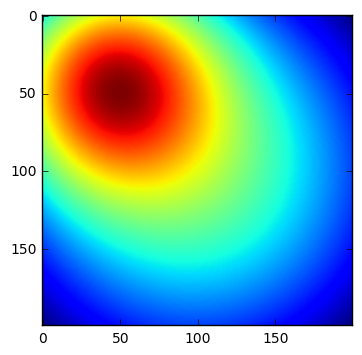

In [7]:
plt.imshow(realK)

In [8]:
data1 = generate_data(n, r, t, X, mu1, sds)

In [9]:
data2 = generate_data(n, r, t, X, mu2, sds)

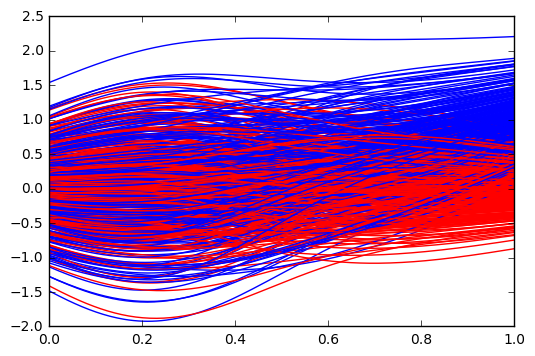

In [10]:
for i in range(n):
    plt.plot(t,data1[i],'r')
    plt.plot(t,data2[i],'b')

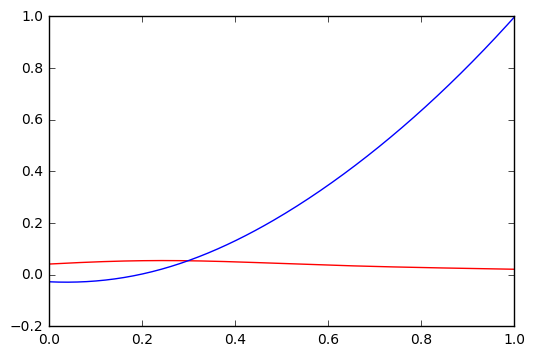

In [11]:
plt.plot(t,data1.mean(0),'r')
plt.plot(t,data2.mean(0),'b')

In [12]:
data_pool = np.r_[data1-data1.mean(0),data2-data2.mean(0)]

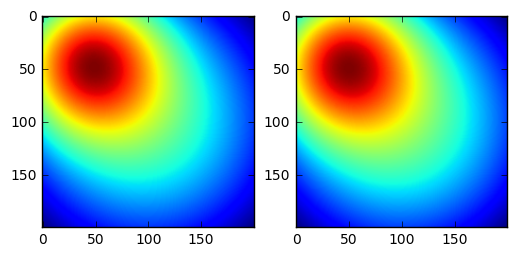

In [13]:
K = np.cov(data_pool, rowvar=False)
#K2 = data_pool.T @ data_pool
plt.subplot(1, 2, 1)
plt.imshow(K)

plt.subplot(1, 2, 2)
plt.imshow(realK)

In [14]:
bla = np.linalg.svd(K)

In [15]:
est_eigv = bla[1][:r]/N

In [16]:
est_eigv

array([  2.45082512e-01,   2.20976985e-02,   5.18325111e-06])

In [17]:
est_eigf = bla[0][:,:r]

In [18]:
mu_coef = (data2.mean(0)-data1.mean(0)) @ est_eigf

In [19]:
mu_coef

array([-2.97863843,  4.71490131, -0.9526082 ])

In [20]:
psi = (mu_coef/est_eigv) @ est_eigf.T

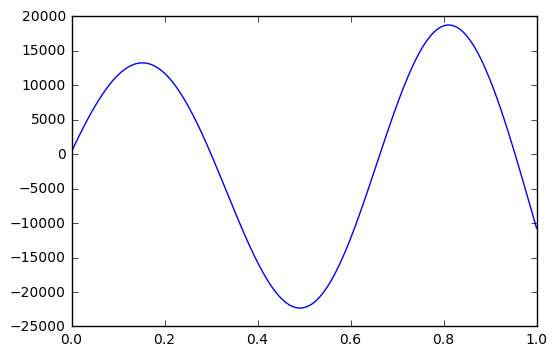

In [21]:
plt.plot(t,psi)

In [22]:
data1.mean(0) @ psi, data2.mean(0) @ psi 

(-42.990450895043224, 176075.11710028304)

In [23]:
def test(Y):
    ans = (Y @ psi - data1.mean(0) @ psi)**2 - (Y @ psi - data2.mean(0) @ psi)**2
    return ans/(N**2)

In [24]:
for i in range(50):
    print(test(data1[i]), test(data2[i]))

-811114.496442 761286.911336
-838210.602266 673752.899788
-857684.462819 794825.293783
-733332.75699 842389.362585
-783725.70211 704179.634761
-831294.881861 732524.080151
-827963.769067 687350.376162
-785552.433013 728145.53396
-837042.787606 740897.456943
-789488.94267 716501.645766
-792360.869504 839123.83464
-833588.788675 809083.962348
-733802.930893 772632.140457
-767370.961265 817967.570852
-788488.479577 733424.77489
-760990.156598 748289.099112
-744922.21799 685173.032182
-863612.349403 779921.701488
-754066.041925 875013.730998
-776405.685445 804882.848802
-830571.025149 780027.452164
-802814.951902 764852.584899
-701159.398819 747167.516806
-795199.795153 794460.365195
-721072.507396 830202.220314
-837647.50354 697517.866336
-869132.29403 843638.312689
-778544.78589 825893.585188
-806610.189712 768026.268667
-760313.140837 833838.777326
-730409.400776 797731.301188
-894593.877339 713867.285598
-865786.03194 916765.998121
-827778.72411 723252.724324
-794812.1228 776127.567495

In [25]:
newX1 = generate_data(1,r,t,X,mu1,sds).ravel()
newX2 = generate_data(1,r,t,X,mu2,sds).ravel()

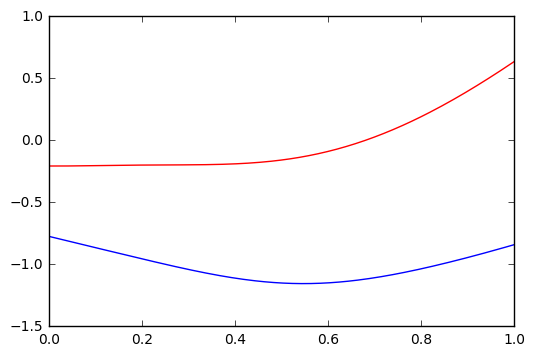

In [26]:
plt.plot(t,newX1,'b')
plt.plot(t,newX2,'r')

In [27]:
test(newX1), test(newX2)

(-685476.25324552518, 724360.78066240507)

In [28]:
results = np.zeros((1,2))
newdata1 = np.zeros((1,N))
newdata2 = np.zeros((1,N))
for _ in range(1000):
    newX1 = generate_data(1,r,t,X,mu1,sds).ravel()
    newX2 = generate_data(1,r,t,X,mu2,sds).ravel()
    newdata1 = np.r_[newdata1, newX1.reshape((1,N))]
    newdata2 = np.r_[newdata2, newX2.reshape((1,N))]
    results = np.r_[results,np.array([test(newX1), test(newX2)]).reshape((1,2))]
results = results[1:]
newdata1 = newdata1[1:]
newdata2 = newdata2[1:]

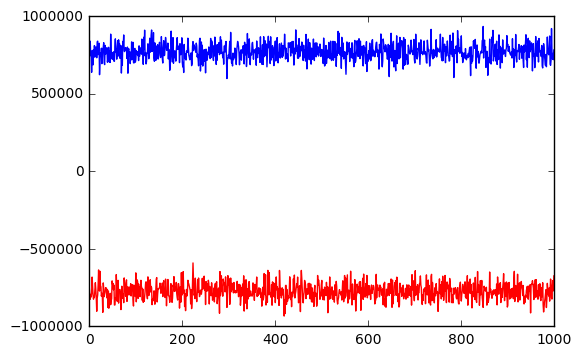

In [29]:
plt.plot(np.arange(1000),results[:,0],'r')
plt.plot(np.arange(1000),results[:,1],'b')

In [30]:
np.mean(results,0)

array([-773017.3209173 ,  771634.73691655])

In [31]:
results[np.argmax(results[:,0]),0]

-590351.17618787021

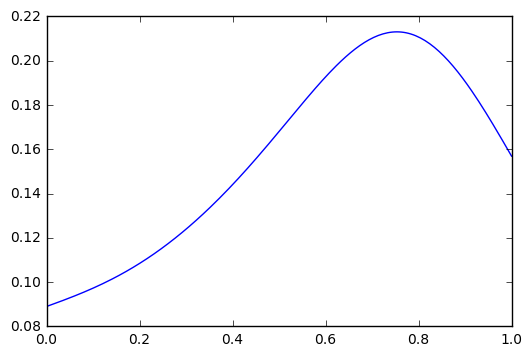

In [32]:
plt.plot(t, newdata1[np.argmax(results[:,0])])

In [33]:
results[np.argmin(results[:,1]),1]

599418.08098612784

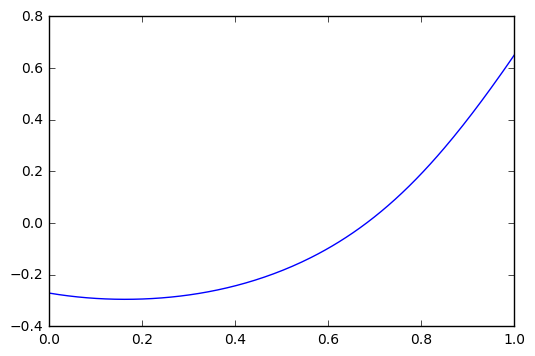

In [34]:
plt.plot(t, newdata2[np.argmin(results[:,1])])

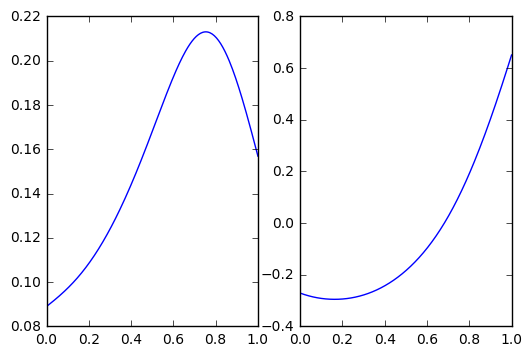

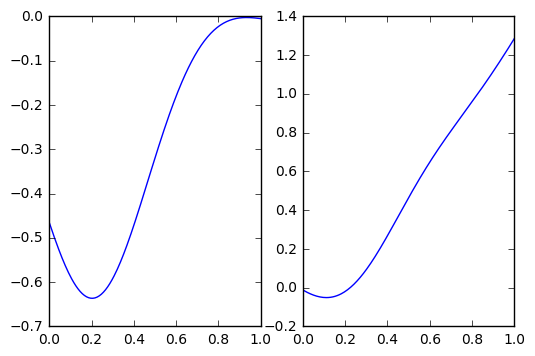

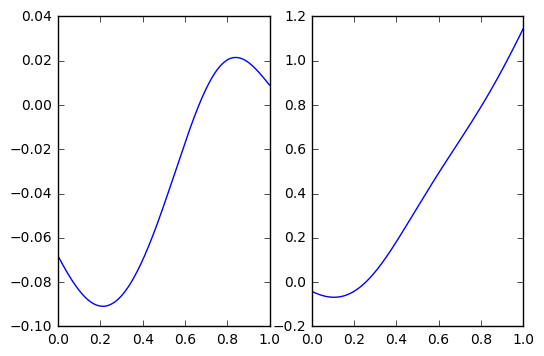

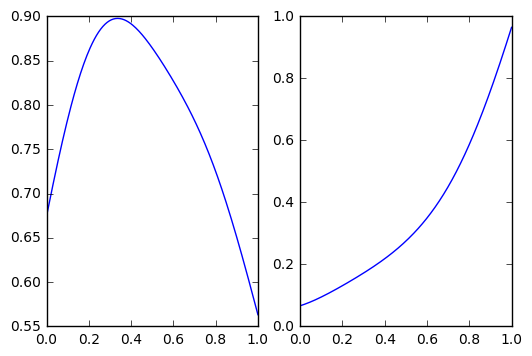

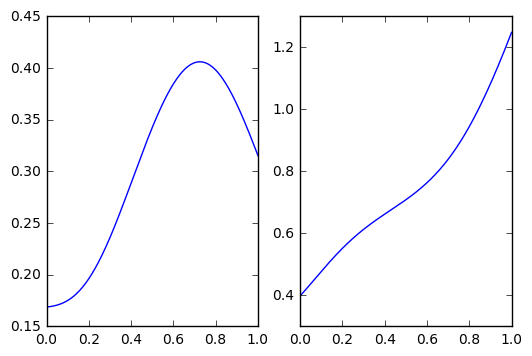

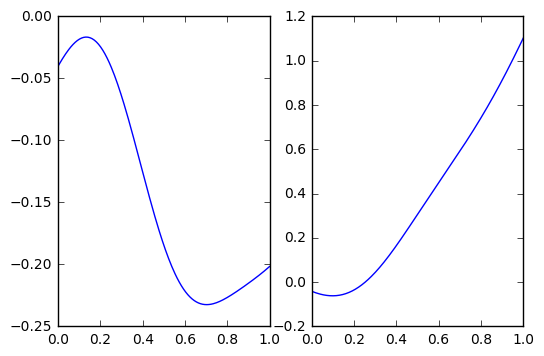

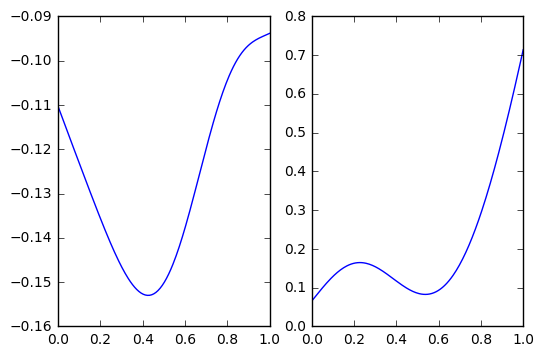

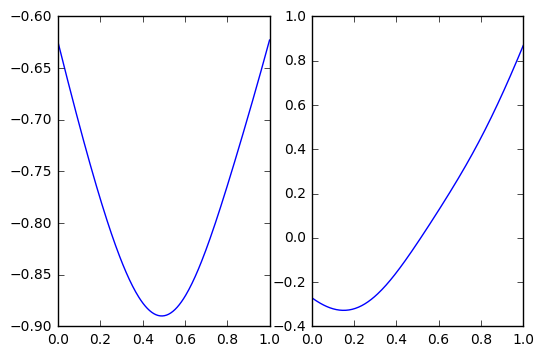

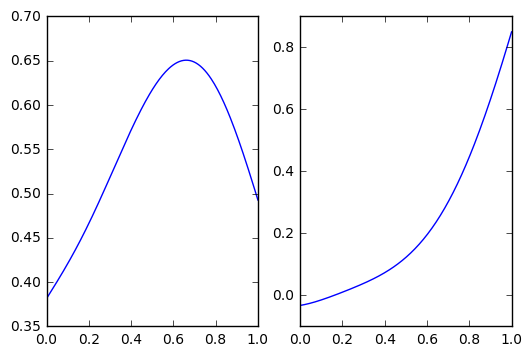

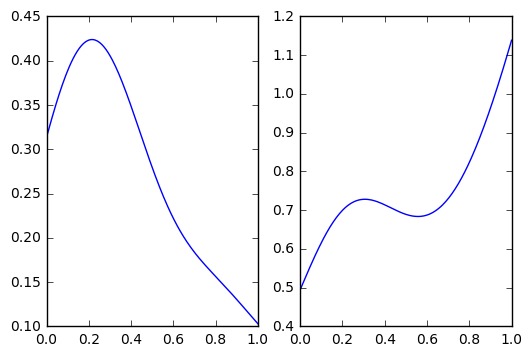

In [35]:
for i in range(10):
    a = np.argsort(results[:,0])[-(i+1)]
    b = np.argsort(results[:,1])[i]
    plt.subplot(1, 2, 1)
    plt.plot(t,newdata1[a])
    plt.subplot(1, 2, 2)
    plt.plot(t,newdata2[b])
    plt.show()

In [36]:
sum(results[:,0]>0)/1000, sum(results[:,1]<0)/1000

(0.0, 0.0)

In [129]:
delta = 0.5

In [130]:
bounds1, bounds21 = get_bounds(delta=delta, N=N, n=n)

In [131]:
bounds2, bounds22 = get_bounds(delta=delta, N=N, n=n)

In [132]:
np.mean(bounds1[:,1]-bounds1[:,0])/N,np.mean(bounds2[:,1]-bounds2[:,0])/N

(0.43715000000000004, 0.43494999999999995)

In [133]:
estmu1 = np.array([hmu(data1,i,bounds1) for i in range(N)])
#estmu1 = mu1(t)

In [134]:
estmu2 = np.array([hmu(data2,i,bounds2) for i in range(N)])
#estmu2 = mu2(t)

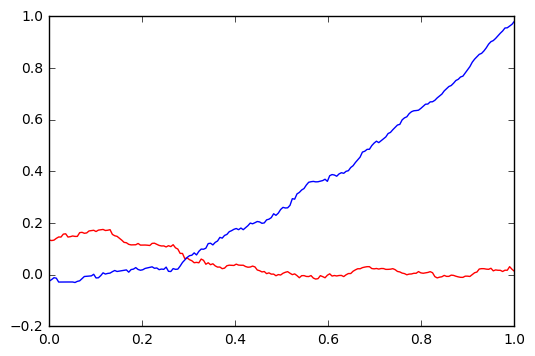

In [135]:
plt.plot(t,estmu1,'r')
plt.plot(t,estmu2,'b')

In [136]:
trunc_cov = get_trunc_cov(np.r_[data1,data2],np.r_[bounds21,bounds22])

In [137]:
P = get_P(N,delta)
tmp = dog(r,P,trunc_cov)[1].reshape((N,-1))
est = tmp @ tmp.T

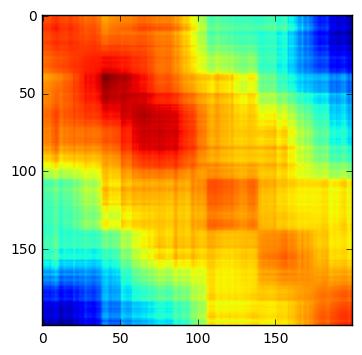

In [138]:
plt.imshow(est)

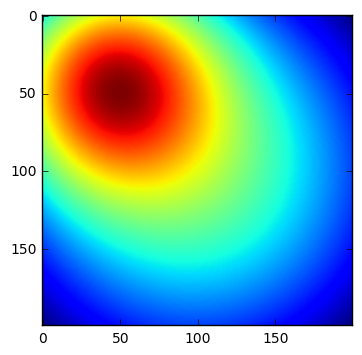

In [139]:
plt.imshow(realK)

In [140]:
score = np.linalg.norm(realK-est)/np.linalg.norm(realK)
print('The relative error is ' + str(score))

The relative error is 0.437084151335


In [141]:
smooth_est = smooth_matrix(est, t)

The relative error w.r.t. the smoothed estimated is 0.416363061342


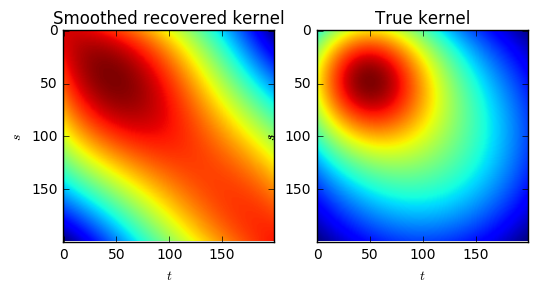

In [142]:
smooth_est = smooth_matrix(est,t)
plt.subplot(1, 2, 1)
plt.imshow(smooth_est)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Smoothed recovered kernel')

plt.subplot(1, 2, 2)
plt.imshow(realK)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('True kernel')

score = np.linalg.norm(realK-smooth_est)/np.linalg.norm(realK)
print('The relative error w.r.t. the smoothed estimated is ' + str(score))

In [143]:
bla = np.linalg.svd(smooth_est)
#bla = np.linalg.svd(smooth_est)

In [144]:
est_eigv = bla[1][:r]/N

In [145]:
est_eigv

array([ 0.21918565,  0.11036118,  0.00350902])

In [146]:
est_eigf = bla[0][:,:r]

In [147]:
mu_coef = (estmu2-estmu1) @ est_eigf

In [148]:
mu_coef

array([-2.75094565,  5.56446913, -0.11796249])

In [149]:
psi = (mu_coef/est_eigv) @ est_eigf.T

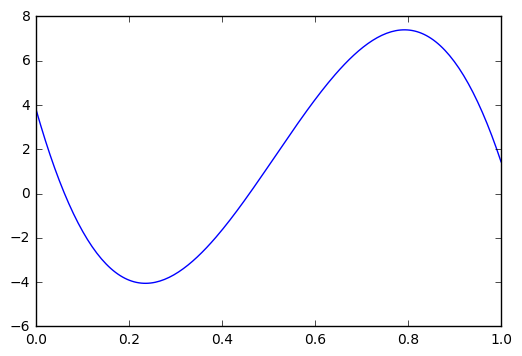

In [150]:
plt.plot(t,psi)

In [151]:
estmu1 @ psi, estmu2 @ psi 

(-13.180761656919895, 305.87470617816655)

In [152]:
def test_frag(Y, start, end):
    ans = (Y[start:end] @ psi[start:end] - estmu1[start:end] @ psi[start:end])**2 - \
          (Y[start:end] @ psi[start:end] - estmu2[start:end] @ psi[start:end])**2
    return ans/((end-start)**2)

In [153]:
train_results = np.zeros((1,2))
for i in range(n):
    qw,er = test_frag(data1[i],bounds1[i][0],bounds1[i][1]), test_frag(data2[i],bounds2[i][0],bounds2[i][1])
    train_results = np.r_[train_results, np.array([qw,er]).reshape((1,2))]
train_results = train_results[1:]

In [154]:
np.argmax(train_results[:,0])

91

In [155]:
np.mean((bounds1[:,1]-bounds1[:,0]))

87.430000000000007

In [156]:
bounds1[277]

array([ 82, 182])

(-334.12483645624104, 3.3931488565227985, 314.768258735855)

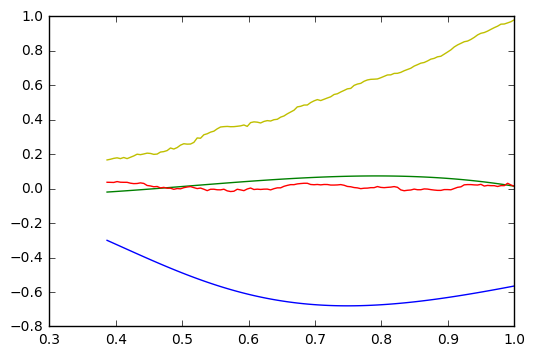

In [157]:
plt.plot(t[77:200],data1[277][77:200])
plt.plot(t[77:200],psi[77:200]/100)
plt.plot(t[77:200],estmu1[77:200],'r')
plt.plot(t[77:200],estmu2[77:200],'y')
data1[277][77:200] @ psi[77:200],estmu1[77:200] @ psi[77:200],estmu2[77:200] @ psi[77:200]

In [158]:
train_results[277]

array([-21.74838995,   3.36361772])

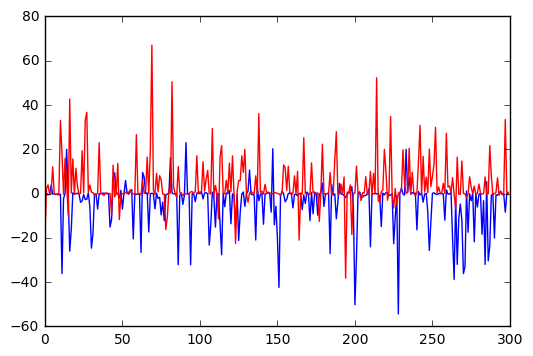

In [159]:
plt.plot(np.arange(n), train_results[:,0],'b')
plt.plot(np.arange(n), train_results[:,1],'r')

In [160]:
train_results.mean(0)

array([-4.14509926,  4.30306008])

In [161]:
sum(train_results[:,0]>0)/n, sum(train_results[:,1]<0)/n

(0.32333333333333331, 0.33000000000000002)

In [162]:
newX1 = generate_data(1,r,t,X,mu1,sds).ravel()
newX2 = generate_data(1,r,t,X,mu2,sds).ravel()

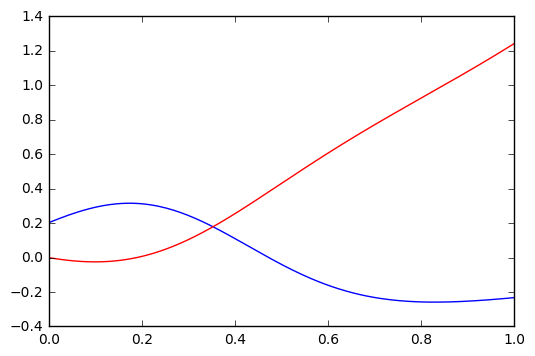

In [163]:
plt.plot(t,newX1,'b')
plt.plot(t,newX2,'r')

In [164]:
get_bounds(N,delta,1)[0].ravel()

array([ 32, 132])

In [165]:
tz = get_bounds(N,delta,1)[0].ravel()
test_frag(newX1,tz[0],tz[1]), test_frag(newX2,tz[0],tz[1])

(-0.04836105928858616, -0.00098686023117596465)

In [166]:
results = np.zeros((1,2))
newdata1 = np.zeros((1,N))
newdata2 = np.zeros((1,N))
for _ in range(1000):
    tz = get_bounds(N,delta,1)[0].ravel()
    newX1 = generate_data(1,r,t,X,mu1,sds).ravel()
    newX2 = generate_data(1,r,t,X,mu2,sds).ravel()
    newdata1 = np.r_[newdata1, newX1.reshape((1,N))]
    newdata2 = np.r_[newdata2, newX2.reshape((1,N))]
    results = np.r_[results,np.array([test_frag(newX1,tz[0],tz[1]), test_frag(newX2,tz[0],tz[1])]).reshape((1,2))]
results = results[1:]
newdata1 = newdata1[1:]
newdata2 = newdata2[1:]

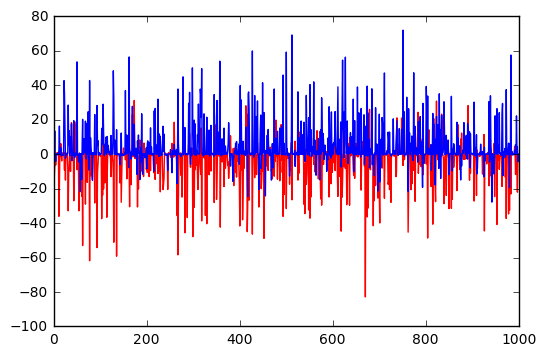

In [167]:
plt.plot(np.arange(1000),results[:,0],'r')
plt.plot(np.arange(1000),results[:,1],'b')

In [168]:
np.mean(results,0)

array([-4.21449371,  4.91492771])

In [169]:
results[np.argmax(results[:,0]),0]

31.228648838436516

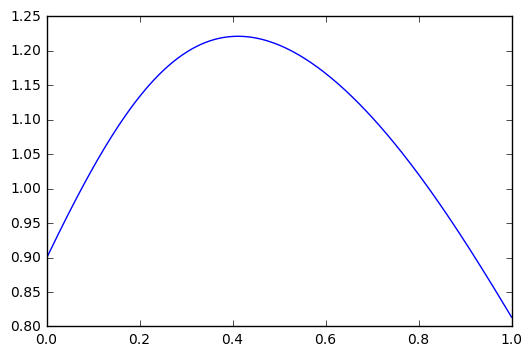

In [170]:
plt.plot(t, newdata1[np.argmax(results[:,0])])

In [171]:
results[np.argmin(results[:,1]),1]

-27.800319945283583

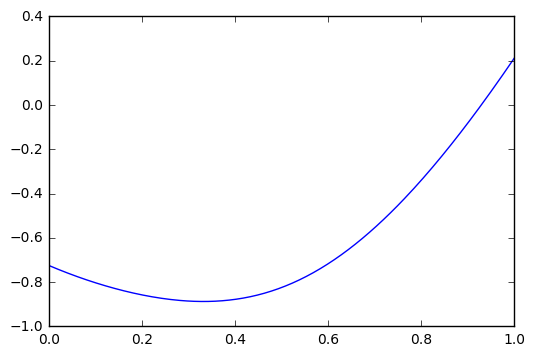

In [172]:
plt.plot(t, newdata2[np.argmin(results[:,1])])

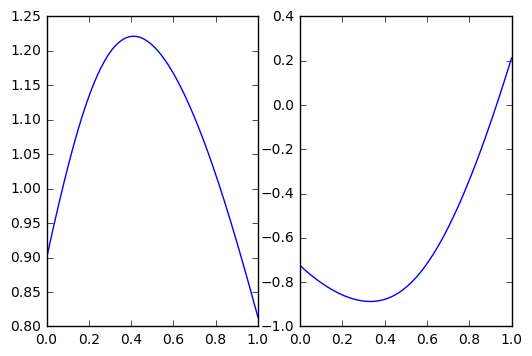

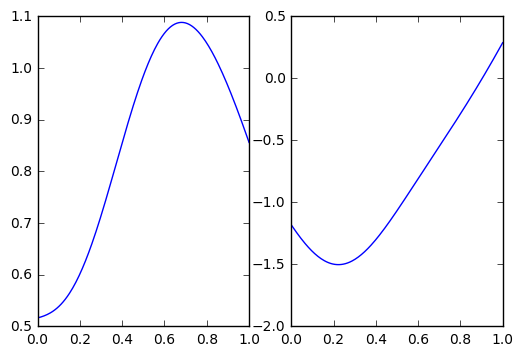

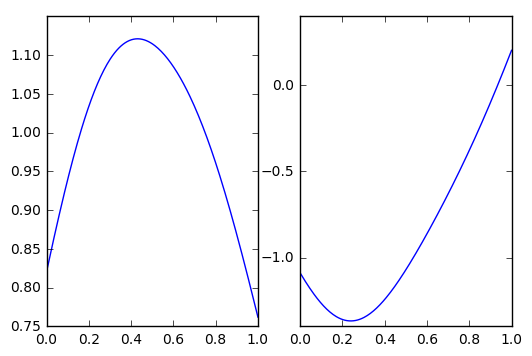

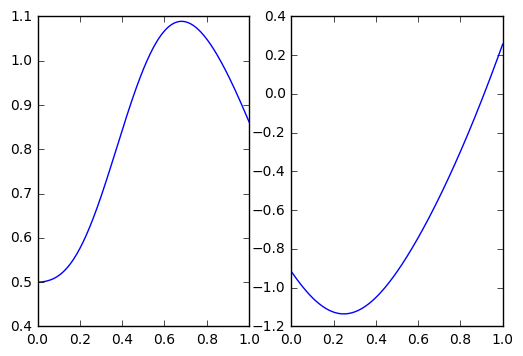

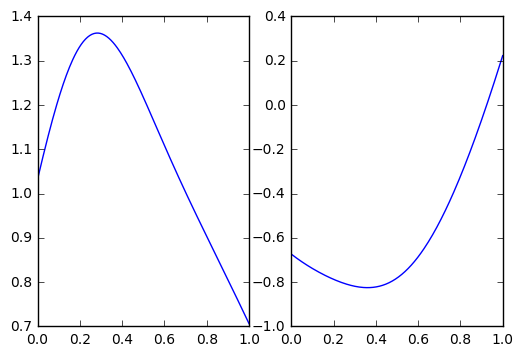

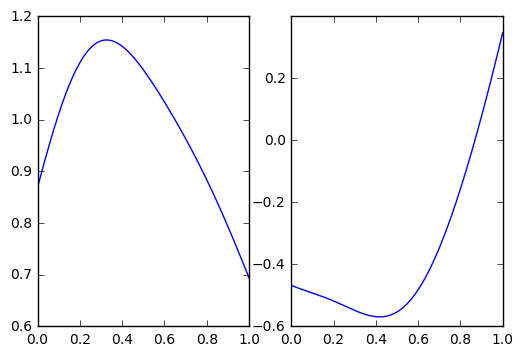

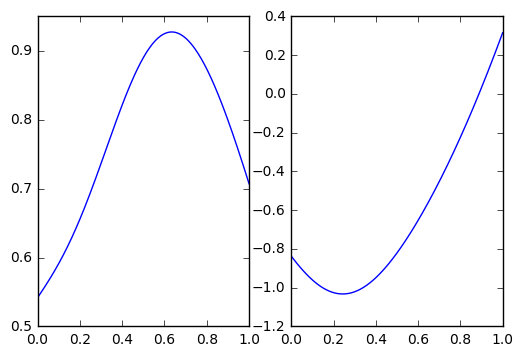

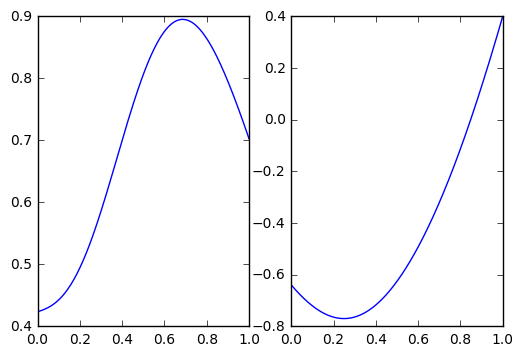

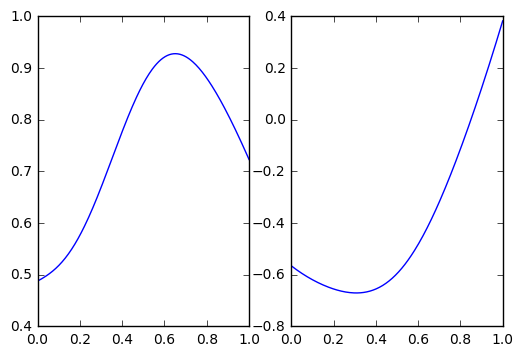

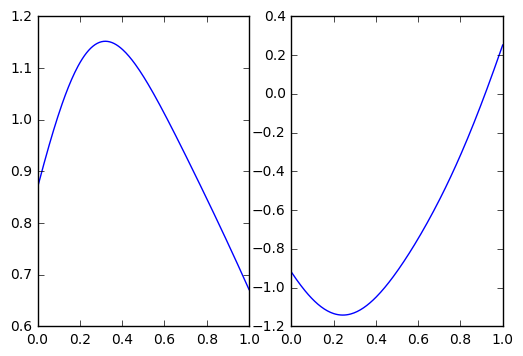

In [173]:
for i in range(10):
    a = np.argsort(results[:,0])[-(i+1)]
    b = np.argsort(results[:,1])[i]
    plt.subplot(1, 2, 1)
    plt.plot(t,newdata1[a])
    plt.subplot(1, 2, 2)
    plt.plot(t,newdata2[b])
    plt.show()

In [174]:
sum(results[:,0]>0)/1000, sum(results[:,1]<0)/1000

(0.39800000000000002, 0.33700000000000002)

([array([   1.,    5.,   25.,   61.,  166.,  703.,   34.,    5.,    0.,    0.]),
  array([   0.,    0.,    0.,    6.,   51.,  742.,  127.,   53.,   16.,    5.])],
 array([-82.88941298, -67.39526923, -51.90112548, -36.40698173,
        -20.91283798,  -5.41869423,  10.07544953,  25.56959328,
         41.06373703,  56.55788078,  72.05202453]),
 <a list of 2 Lists of Patches objects>)

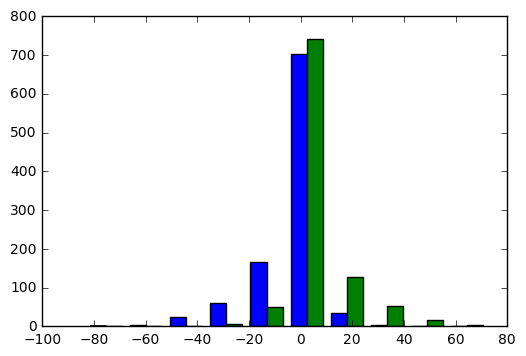

In [175]:
plt.hist(results)